In [2]:
# MLの基礎ライブラリ
import numpy as np
import pandas as pd
import pandas.plotting as pl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap  # グラフの色付け
%matplotlib inline
# 前処理
from sklearn.model_selection import train_test_split, GridSearchCV  # データ分割
from sklearn.experimental import enable_iterative_imputer  # IterativeImputerの呼び出し
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer  # 欠損値補完
from sklearn.preprocessing import StandardScaler  # 特徴量標準化
# 次元削減
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
# モデル
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
# スコア
from sklearn.metrics import f1_score
# バイナリオブジェクト
import pickle

In [40]:
# データフレーム
csv_name = 'csv/train.csv'
df = pd.read_csv(csv_name)

x = df.drop(columns='Survived', axis=1)
y = df.Survived

# 不要な特徴量を削除
drop_col = ['PassengerId', 'Pclass', 'Name', 'Ticket']
x = x.drop(columns=drop_col)
x.sample(5)

,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
106,female,21.0,0,0,7.6500,NaN,S
259,female,50.0,0,1,26.0000,NaN,S
633,male,NaN,0,0,0.0000,NaN,S
206,male,32.0,1,0,15.8500,NaN,S
862,female,48.0,0,0,25.9292,D17,S


In [41]:
%%time
# ダミー変数化
df = pd.get_dummies(x, dummy_na=True)

# 欠損値確認
print(df.isnull().sum())

# 平均値補完
imp = SimpleImputer()
imp.fit(df)
x_col = df.columns.values
x_new = pd.DataFrame(imp.transform(df), columns=x_col)

# 多重代入法による補完
# ite = IterativeImputer()
# ite.fit(df)
# x_col = df.columns.values
# x_new = pd.DataFrame(imp.transform(df), columns=x_col)

# データ標準化
sta = StandardScaler()
X = sta.fit_transform(x_new)
x_new.sample(5)

Age             177
SibSp             0
Parch             0
Fare              0
Sex_female        0
               ... 
Cabin_nan         0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Embarked_nan      0
Length: 159, dtype: int64
Wall time: 59 ms


,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Sex_nan,Cabin_A10,Cabin_A14,Cabin_A16,...,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Cabin_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
246,25.000000,0.0,0.0,7.7750,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
351,29.699118,0.0,0.0,35.0000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
136,19.000000,0.0,2.0,26.2833,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
793,29.699118,0.0,0.0,30.6958,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
239,33.000000,0.0,0.0,12.2750,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [42]:
%%time
# 特徴量選択
est = DecisionTreeClassifier(random_state=3)
selector = RFE(est, step=.01, n_features_to_select=80)
selected_x = selector.fit_transform(X, y)

# データフレームへ
x_col = x_col[selector.support_]
X = pd.DataFrame(selected_x, columns=x_col)

Wall time: 782 ms


In [43]:
# 主成分分析
pca = PCA(n_components=2, random_state=3)
X = pca.fit_transform(X)
# データ分割
x_train, x_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=3)

In [44]:
# モデル辞書
models = {
    'k_neig': KNeighborsClassifier(),
    'tree': DecisionTreeClassifier(random_state=3),
    'rfc': RandomForestClassifier(random_state=3),
    'svc': SVC(random_state=3),
    'gaus_C': GaussianProcessClassifier(random_state=3),
    'gaus_NB': GaussianNB(),
}

In [49]:
%%time
# ハイパーパラメーター
para_dic = {
    'n_restarts_optimizer': [0, 10, 100],
    'max_iter_predict': [10, 100, 1000]
}
clf = GridSearchCV(models['gaus_C'], para_dic, cv=5)
clf.fit(x_train, y_train)

Wall time: 9.3 s


GridSearchCV(cv=5, error_score=nan,
             estimator=GaussianProcessClassifier(copy_X_train=True, kernel=None,
                                                 max_iter_predict=100,
                                                 multi_class='one_vs_rest',
                                                 n_jobs=None,
                                                 n_restarts_optimizer=0,
                                                 optimizer='fmin_l_bfgs_b',
                                                 random_state=3,
                                                 warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'max_iter_predict': [10, 100, 1000],
                         'n_restarts_optimizer': [0, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [8]:
# モデルの学習
for model in models.values():
    model.fit(x_train, y_train)
print('>>> learning done!')

>>> learning done!


In [9]:
# モデル評価
result = []
for mo in models.values():
    train = round(mo.score(x_train, y_train), 6)
    test = round(mo.score(x_test, y_test), 6)
    result.append([train, test])
# 列と行の名前
col = ['train_score', 'test_score']
row = ['k_neig', 'tree', 'rfc', 'svc', 'gaus_C', 'gaus_NB']
# スコアをデータフレームにする
rdf = pd.DataFrame(result, columns=col, index=row)
rdf

,train_score,test_score
k_neig,0.847512,0.772388
tree,0.990369,0.746269
rfc,0.990369,0.750000
svc,0.808989,0.764925
gaus_C,0.812199,0.772388
gaus_NB,0.767255,0.746269


In [10]:
# F値の評価
result_f = []
for mo in models.values():
    train = f1_score(y_train, mo.predict(x_train))
    test = f1_score(y_test, mo.predict(x_test))
    result_f.append([train, test])
fdf = pd.DataFrame(result_f, columns=col, index=row)
fdf

,train_score,test_score
k_neig,0.791209,0.690355
tree,0.987288,0.673077
rfc,0.987288,0.673171
svc,0.725173,0.689655
gaus_C,0.732265,0.699507
gaus_NB,0.657210,0.653061


In [10]:
# # 正解率の高いモデルを選択
# score = 0
# model_name = ''
# for name, model in models.items():
#     if model.score(x_test, y_test) > score:
#         score = model.score(x_test, y_test)
#         model_name = name
# print(f'>>> Selected "{model_name}"!')

>>> Selected "k_neig"!


In [11]:
# F値の高いモデルを選択
score = 0
name = ''
for i in range(len(fdf.test_score)):
    if fdf.test_score[i] > score:
        score = fdf.test_score[i]
        name = list(fdf.index)[i]
print(f'>>> Selected "{name}"!')

>>> Selected "gaus_C"!


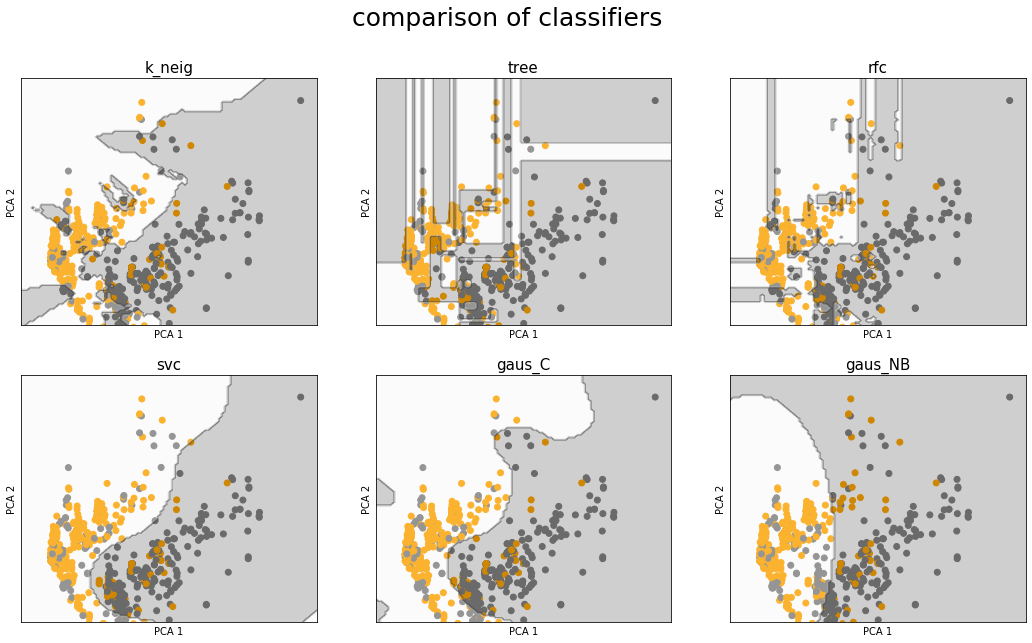

In [21]:
# 色の定義
fig, axs = plt.subplots(2, 3, figsize=(18,10))
fig.suptitle('comparison of classifiers', size=25)
cm = plt.cm.binary
cm_bright = ListedColormap(['orange', 'gray'])

# グラフの色付けエリアの定義
h = .1
x_min, x_max = X[:, 0].min() - 1, X[:, 1].max() + 1
y_min, y_max = X[:, 0].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

# グラフの色付け
def draw_graph(title, i, j, model):
    # ラベル可視化
    axs[i, j].scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cm_bright)
    axs[i, j].scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cm_bright)
    # 分類エリア可視化
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axs[i, j].contourf(xx, yy, Z, cmap=cm, alpha=.2)
    axs[i, j].grid()
    axs[i, j].set_xlabel('PCA 1', size=10)
    axs[i, j].set_ylabel('PCA 2', size=10)
    axs[i, j].set_title(title, size=15)
    # グラフのX軸、y軸の長さ整形
    axs[i, j].set_xlim(xx.min(), xx.max())
    axs[i, j].set_ylim(yy.min(), yy.max())
    axs[i, j].set_xticks(())
    axs[i, j].set_yticks(())

# 関数の引数リスト
args = [['k_neig', 0, 0, models['k_neig']],
        ['tree', 0, 1, models['tree']],
        ['rfc', 0, 2, models['rfc']],
        ['svc', 1, 0, models['svc']],
        ['gaus_C', 1, 1, models['gaus_C']],
        ['gaus_NB', 1, 2, models['gaus_NB']]]
        
# プロット
for li in args:
    draw_graph(*li)
plt.savefig('fig_1.png')
plt.show()

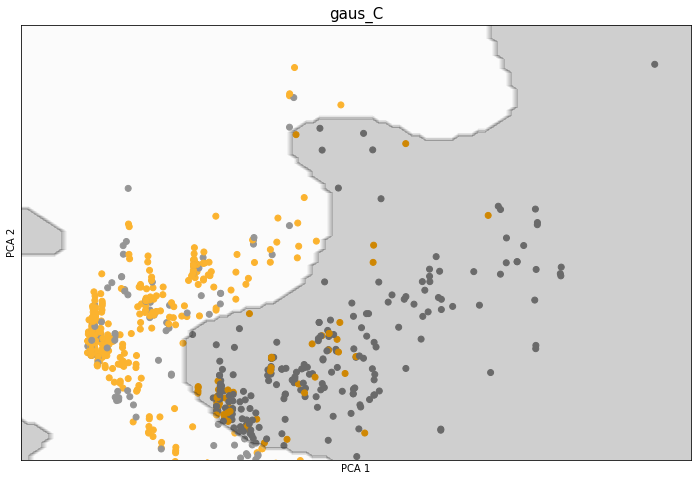

In [24]:
# 選択したモデルのグラフ
fig, ax = plt.subplots(figsize=(12,8))

# ラベル可視化
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cm_bright)
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cm_bright)
# 分類エリア可視化
Z = models[name].predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.2)
ax.set_xlabel('PCA 1', size=10)
ax.set_ylabel('PCA 2', size=10)
ax.set_title(name, size=15)
# グラフのX軸、y軸の長さ整形
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

plt.savefig('fig_2.png')
plt.show()